2024-06-24    4.25
2024-06-25    4.23
2024-06-26    4.32
2024-06-27    4.29
2024-06-28    4.36
dtype: float64


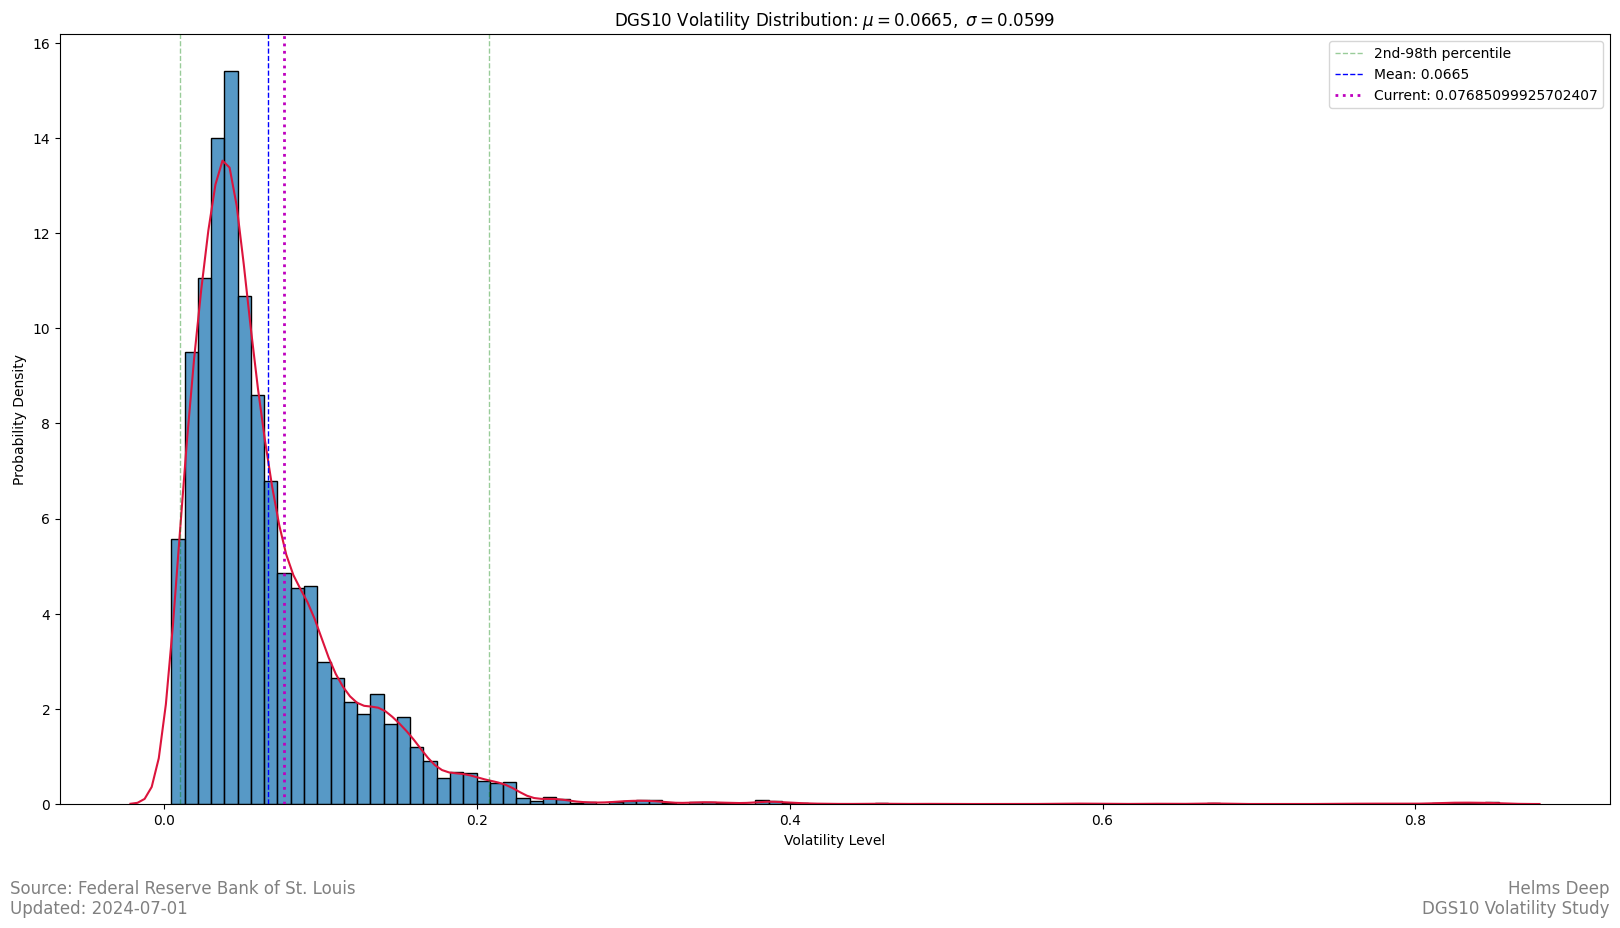

In [12]:
import os
import sys
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def fetch_dgs10_data():
    """
    Fetch DGS10 data from the FRED API using SeriesFetcher.
    
    Returns:
        pd.Series: A series containing DGS10 data.
    """
    DGS10 = SeriesFetcher('DGS10')
    dgs10_df = DGS10.get_series_data()
    return dgs10_df

def calculate_volatility(series, window=30):
    """
    Calculate the rolling volatility of a time series.

    Parameters:
        series (pd.Series): A time series of data.
        window (int): The rolling window size.

    Returns:
        pd.Series: A series containing the rolling volatility.
    """
    return series.pct_change().rolling(window=window).std() * np.sqrt(window)

def plot_volatility_distribution(volatility_df):
    """
    Plot the distribution and statistics of volatility data.

    Parameters:
        volatility_df (pd.Series): A series containing volatility data.
    """
    today = pd.Timestamp.now().date()
    mu = np.mean(volatility_df)
    sigma = np.std(volatility_df)

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.histplot(volatility_df.dropna(), bins=100, stat='density', kde=False)
    sns.kdeplot(volatility_df.dropna(), color='crimson')

    ax.set_xlabel('Volatility Level')
    ax.set_ylabel('Probability Density')
    ax.set_title(r'DGS10 Volatility Distribution: $\mu={:.4f},\ \sigma={:.4f}$'.format(mu, sigma))
    
    ax.axvline(np.percentile(volatility_df.dropna(), 2), color='g', alpha=0.4, linestyle='dashed', linewidth=1, label='2nd-98th percentile')
    ax.axvline(np.percentile(volatility_df.dropna(), 98), color='g', alpha=0.4, linestyle='dashed', linewidth=1)
    ax.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Mean: {round(mu, 4)}')
    ax.axvline(volatility_df.iloc[-1], color='m', linestyle=':', linewidth=2, label=f'Current: {volatility_df.iloc[-1]}')

    most_recent_date = volatility_df.index.max()
    # plt.text(0.98, 0.98, f'Most Recent Data: {most_recent_date.date()}', 
    #          transform=plt.gca().transAxes, fontsize=12, color='grey', ha='right', va='top')

    # Add signature text to the plot
    signature_text = 'Helms Deep\nDGS10 Volatility Study'
    plt.figtext(.9, 0, signature_text, ha='right', fontsize=12, color='grey')
    
    # Add source from FRED St. Louis on the left
    plt.figtext(0.1, 0, f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}', ha='left', fontsize=12, color='grey')

    plt.legend(loc="upper right")
    # add_signature_bar(fig, "The Horn of Helm Hammerhand will sound in the deep, one last time!")

    plt.show()

if __name__ == "__main__":
    dgs10_df = fetch_dgs10_data()
    print(dgs10_df.tail())
    dgs10_volatility = calculate_volatility(dgs10_df)
    plot_volatility_distribution(dgs10_volatility)


            DGS10    VIX  DGS10_Returns  DGS10_Volatility  \
2024-06-26   4.32  12.55       0.021277          0.252907   
2024-06-27   4.29  12.24      -0.006944          0.243450   
2024-06-28   4.36  12.44       0.016317          0.244305   
2024-07-01   4.48  12.22       0.027523          0.262114   
2024-07-02   4.43  12.03      -0.011161          0.263172   

            Normalized_DGS10_Volatility  Normalized_VIX  
2024-06-26                     0.088114        0.151772  
2024-06-27                     0.084819        0.148023  
2024-06-28                     0.085117        0.150441  
2024-07-01                     0.091321        0.147781  
2024-07-02                     0.091690        0.145483  


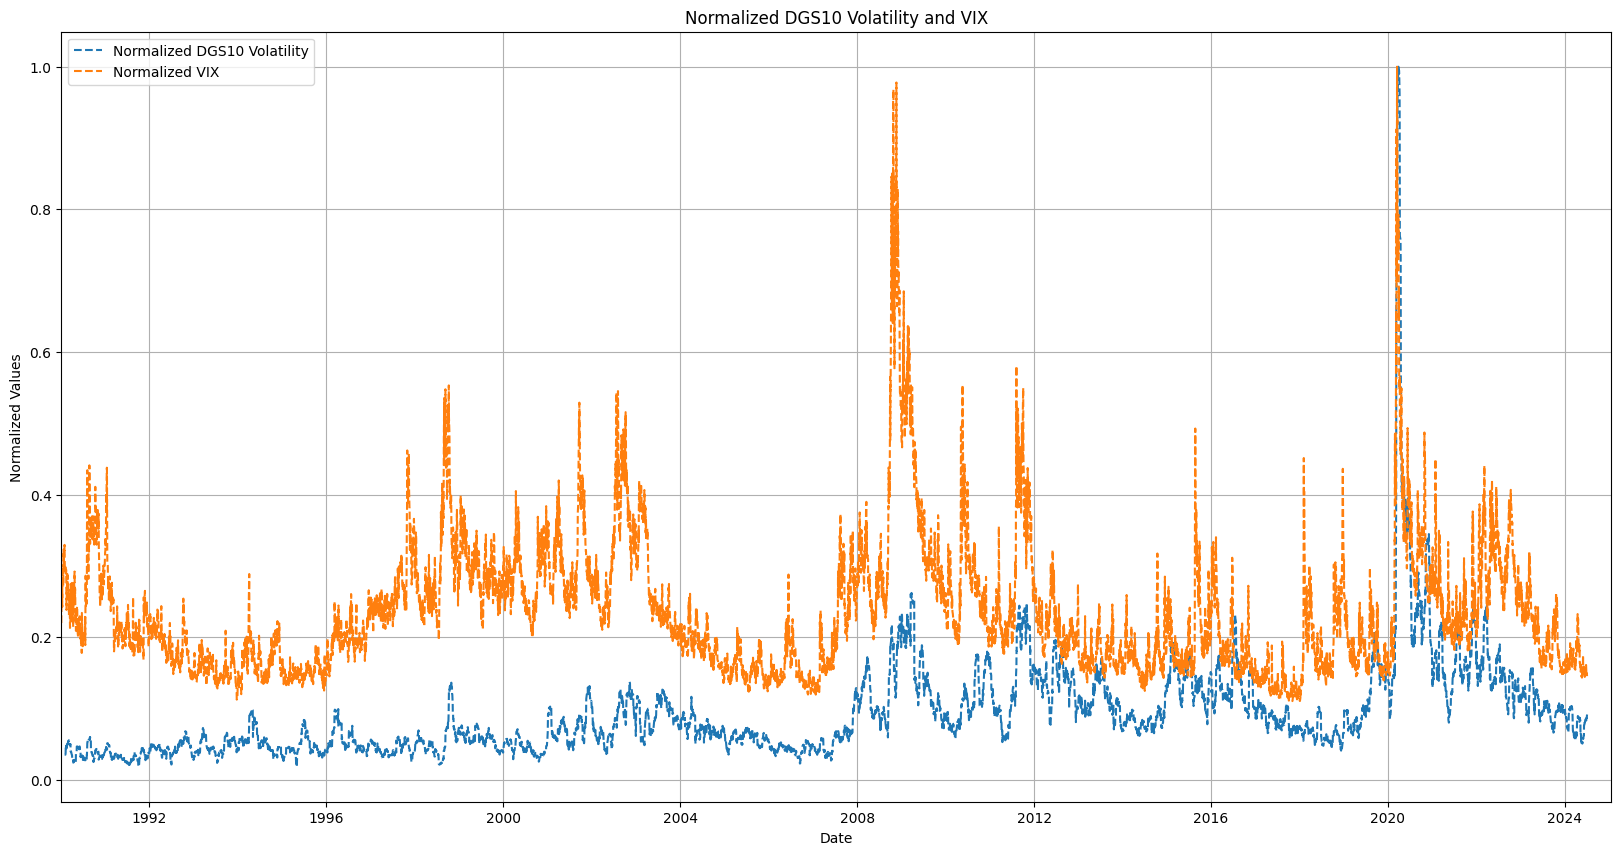

In [29]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

# Fetch DGS10 data (Yield on U.S. Treasury Securities at 10-Year)
dgs10_fetcher = SeriesFetcher('DGS10')
dgs10_data = dgs10_fetcher.get_series_data()

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Convert index to datetime
dgs10_data.index = pd.to_datetime(dgs10_data.index)
vix_data.index = pd.to_datetime(vix_data.index)

# Align both datasets on the same date index
combined_data = pd.DataFrame({'DGS10': dgs10_data, 'VIX': vix_data}).dropna()

# Specify arbitrary start date
# start_date = dt.strptime('01-01-2020', "%m-%d-%Y")
start_date = combined_data.index[1]

# Filter data based on start date
combined_data = combined_data.loc[start_date:]

# Calculate Historical (Realized) Volatility for DGS10
combined_data['DGS10_Returns'] = combined_data['DGS10'].pct_change()
combined_data['DGS10_Volatility'] = combined_data['DGS10_Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
combined_data['Normalized_DGS10_Volatility'] = combined_data['DGS10_Volatility'] / combined_data['DGS10_Volatility'].max()
combined_data['Normalized_VIX'] = combined_data['VIX'] / combined_data['VIX'].max()

# Plotting
plt.subplots(figsize=(20, 10))

# Set x-axis limits to include additional offset days
offset_days = 200
x_min = combined_data.index.min()
x_max = combined_data.index.max() + pd.DateOffset(days=offset_days)
plt.xlim(x_min, x_max)

# Plot Normalized DGS10 Volatility
plt.plot(combined_data.index, combined_data['Normalized_DGS10_Volatility'], label='Normalized DGS10 Volatility', linestyle='--')

# Plot Normalized VIX Data
plt.plot(combined_data.index, combined_data['Normalized_VIX'], label='Normalized VIX', linestyle='--')

# Plot settings
plt.title('Normalized DGS10 Volatility and VIX')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)

print(combined_data.tail())

plt.show()


1990-01-03 00:00:00


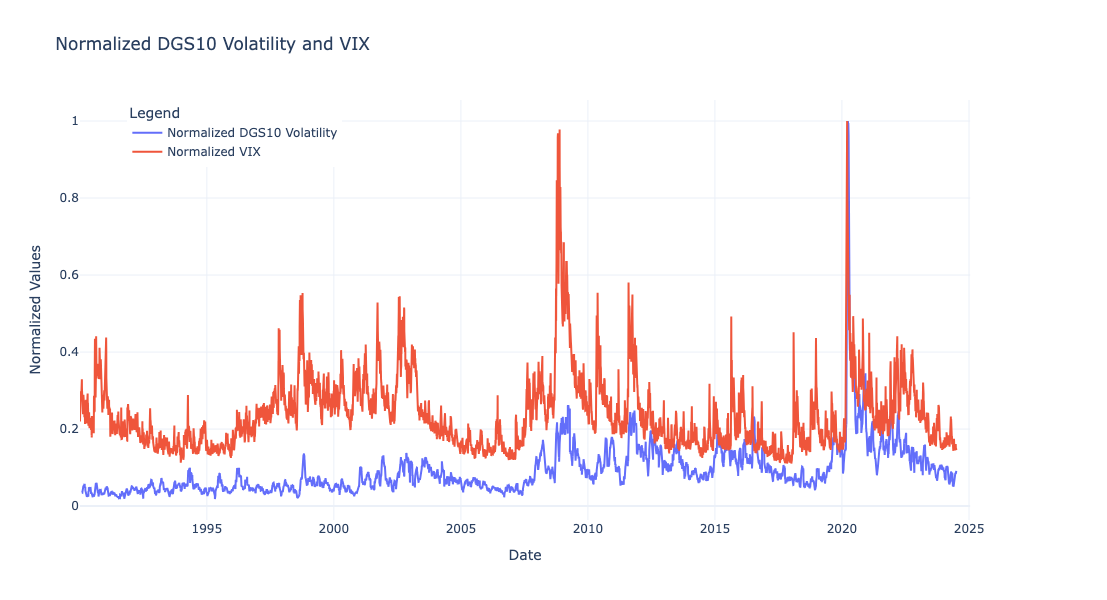

In [38]:
import os
import sys
import pandas as pd
import plotly.graph_objs as go
from datetime import datetime as dt
from plotly.subplots import make_subplots

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

# Fetch DGS10 data (Yield on U.S. Treasury Securities at 10-Year)
dgs10_fetcher = SeriesFetcher('DGS10')
dgs10_data = dgs10_fetcher.get_series_data()

# Fetch VIXCLS data (Implied Volatility)
vix_fetcher = SeriesFetcher('VIXCLS')
vix_data = vix_fetcher.get_series_data()

# Convert index to datetime
dgs10_data.index = pd.to_datetime(dgs10_data.index)
vix_data.index = pd.to_datetime(vix_data.index)

# Align both datasets on the same date index
combined_data = pd.DataFrame({'DGS10': dgs10_data, 'VIX': vix_data}).dropna()

# Specify arbitrary start date
# start_date = dt.strptime('01-01-2020', "%m-%d-%Y")

# Filter data based on start date

start_date = combined_data.index[1] 

print(start_date)
combined_data = combined_data.loc[start_date:]

# Calculate Historical (Realized) Volatility for DGS10
combined_data['DGS10_Returns'] = combined_data['DGS10'].pct_change()
combined_data['DGS10_Volatility'] = combined_data['DGS10_Returns'].rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Normalize the volatilities
combined_data['Normalized_DGS10_Volatility'] = combined_data['DGS10_Volatility'] / combined_data['DGS10_Volatility'].max()
combined_data['Normalized_VIX'] = combined_data['VIX'] / combined_data['VIX'].max()

# Create the plot with Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Normalized DGS10 Volatility trace
fig.add_trace(
    go.Scatter(x=combined_data.index, y=combined_data['Normalized_DGS10_Volatility'],
               mode='lines', name='Normalized DGS10 Volatility', line=dict(dash='solid')),
    secondary_y=False,
)

# Add Normalized VIX trace
fig.add_trace(
    go.Scatter(x=combined_data.index, y=combined_data['Normalized_VIX'],
               mode='lines', name='Normalized VIX', line=dict(dash='solid')),
    secondary_y=False,
)

# Set x-axis limits to include additional offset days
offset_days = 200
x_min = combined_data.index.min()
x_max = combined_data.index.max() + pd.DateOffset(days=offset_days)
fig.update_xaxes(range=[x_min, x_max])

# Update layout with custom size and legend position
fig.update_layout(
    title='Normalized DGS10 Volatility and VIX',
    xaxis_title='Date',
    yaxis_title='Normalized Values',
    legend_title='Legend',
    template='plotly_white',
    width=1200,  # Set the width of the plot
    height=600,   # Set the height of the plot
    legend=dict(
        x=.05,
        y=1,
        xanchor='left',
        yanchor='top',
    )
)

# Show the plot
fig.show()


2024-06-26    12.55
2024-06-27    12.24
2024-06-28    12.44
2024-07-01    12.22
2024-07-02    12.03
dtype: float64


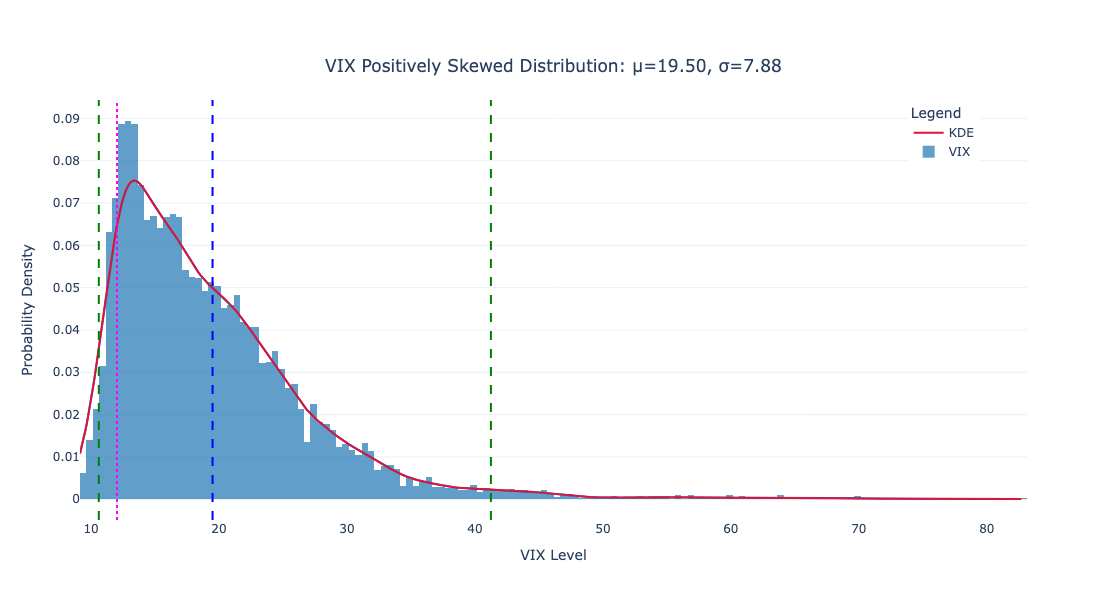

In [41]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.figure_factory as ff
from datetime import datetime
from fredapi import Fred
from scipy.stats import gaussian_kde
import importlib

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def fetch_vix_data():
    """
    Fetch VIX data from the FRED API using SeriesFetcher.
    
    Returns:
        pd.Series: A series containing VIX data.
    """
    VIXCLS = SeriesFetcher('VIXCLS')
    vix_df = VIXCLS.get_series_data()
    return vix_df

def plot_vix_distribution(vix_df):
    """
    Plot the distribution and statistics of VIX data using Plotly.

    Parameters:
        vix_df (pd.Series): A series containing VIX data.
    """
    today = pd.Timestamp.now().date()
    mu = np.mean(vix_df)
    sigma = np.std(vix_df)

    hist_data = [vix_df]
    group_labels = ['VIX']

    # Create distplot with custom bin_size
    fig = ff.create_distplot(hist_data, group_labels, bin_size=0.5, show_rug=False)

    # Compute KDE using gaussian_kde
    kde = gaussian_kde(vix_df)
    x_vals = np.linspace(min(vix_df), max(vix_df), 1000)
    kde_vals = kde(x_vals)

    # Add KDE plot
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=kde_vals,
            mode='lines',
            name='KDE',
            line=dict(color='crimson')
        )
    )

    # Add vertical lines for mean and percentiles
    fig.add_vline(x=np.percentile(vix_df, 2), line=dict(color='green', dash='dash'), annotation_text='2nd percentile', annotation_position='top left')
    fig.add_vline(x=np.percentile(vix_df, 98), line=dict(color='green', dash='dash'), annotation_text='98th percentile', annotation_position='top right')
    fig.add_vline(x=mu, line=dict(color='blue', dash='dash'), annotation_text=f'Mean: {mu:.2f}', annotation_position='top left')
    fig.add_vline(x=vix_df.iloc[-1], line=dict(color='magenta', dash='dot'), annotation_text=f'Current: {vix_df.iloc[-1]:.2f}', annotation_position='top right')

    # Update layout
    fig.update_layout(
        title={
            'text': f'VIX Positively Skewed Distribution: μ={mu:.2f}, σ={sigma:.2f}',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='VIX Level',
        yaxis_title='Probability Density',
        legend_title='Legend',
        legend=dict(
            x=.95,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the plot
        height=600,   # Set the height of the plot
        annotations=[
            dict(
                text=f'Source: Federal Reserve Bank of St. Louis\nUpdated: {today}',
                xref='paper', yref='paper',
                x=0, y=-0.2,
                showarrow=False,
                font=dict(size=12, color='grey'),
                xanchor='left', yanchor='top'
            ),
            dict(
                text='Helms Deep\nVIX Index Histogram Study',
                xref='paper', yref='paper',
                x=1, y=-0.2,
                showarrow=False,
                font=dict(size=12, color='grey'),
                xanchor='right', yanchor='top'
            )
        ]
    )

    # Show the plot
    fig.show()

if __name__ == "__main__":
    vix_df = fetch_vix_data()
    print(vix_df.tail())
    plot_vix_distribution(vix_df)


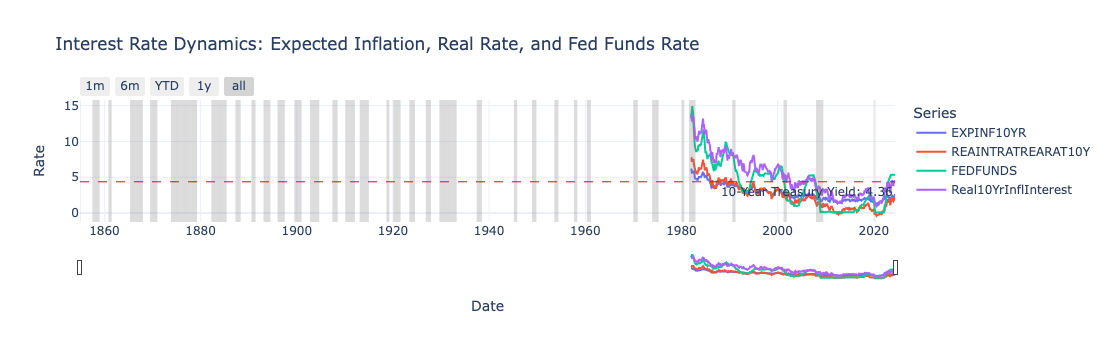

In [52]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(fig, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 2000
    
    # Construct the RealFlation DataFrame
    RealFlation = constructDF()
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add traces for each series
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['EXPINF10YR'], mode='lines', name='EXPINF10YR'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['REAINTRATREARAT10Y'], mode='lines', name='REAINTRATREARAT10Y'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='FEDFUNDS'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['Real10YrInflInterest'], mode='lines', name='Real10YrInflInterest'))
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(start_date=start_date)
    shade_recession_months(fig, usrec_series)
    
    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'10-Year Treasury Yield: {current_dgs10}', annotation_position='bottom right')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")
    
    # Update layout
    fig.update_layout(
        title='Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        template='plotly_white',
        xaxis=dict(rangeselector=dict(buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])),
        rangeslider=dict(visible=True), type="date")
    )
    
    # Show the figure
    fig.show()


In [47]:
RealFlation.index[1] 

Timestamp('1982-02-01 00:00:00')

In [50]:
RealFlation.head(5)

EXPINF10YR  REAINTRATREARAT10Y  FEDFUNDS  Real10YrInflInterest
1982-01-01    6.197611            7.623742     13.22             13.821354
1982-02-01    6.079232            7.656648     14.78             13.735880
1982-03-01    5.648130            7.128993     14.68             12.777123
1982-04-01    5.713188            7.408347     14.94             13.121536
1982-05-01    5.689980            7.320041     14.45             13.010021

In [56]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

from fetcher import SeriesFetcher

def constructDF(start_date=None):
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(start_date=start_date),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(start_date=start_date),
        'FEDFUNDS': fedfunds.get_series_data(start_date=start_date)
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(fig, usrec_series, min_date):
    """
    Shades the recession months based on the "USREC" series, excluding data prior to min_date.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
        min_date (pd.Timestamp): The minimum date to include in the plot.
    """
    usrec_filtered = usrec_series[usrec_series.index >= min_date]
    for date, value in usrec_filtered.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 2000

    # Construct the RealFlation DataFrame
    RealFlation = constructDF(start_date=start_date)
    
    # Get the actual data range
    data_start_date = RealFlation.index.min()
    data_end_date = RealFlation.index.max()
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add traces for each series
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['EXPINF10YR'], mode='lines', name='EXPINF10YR'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['REAINTRATREARAT10Y'], mode='lines', name='REAINTRATREARAT10Y'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='FEDFUNDS'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['Real10YrInflInterest'], mode='lines', name='Real10YrInflInterest'))
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(start_date=start_date)
    shade_recession_months(fig, usrec_series, data_start_date)
    
    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'10-Year Treasury Yield: {current_dgs10}', annotation_position='bottom right')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")
    
    # Update layout with correct x-axis range and range slider range
    fig.update_layout(
        title='Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        template='plotly_white',
        xaxis=dict(
            rangeselector=dict(buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])),
            rangeslider=dict(visible=True, range=[data_start_date, data_end_date]), 
            type="date",
            range=[data_start_date, data_end_date + pd.DateOffset(days=offset_days)]
        )
    )
    
    # Show the figure
    fig.show()


TypeError: '>=' not supported between instances of 'str' and 'Timestamp'

In [55]:
USREC

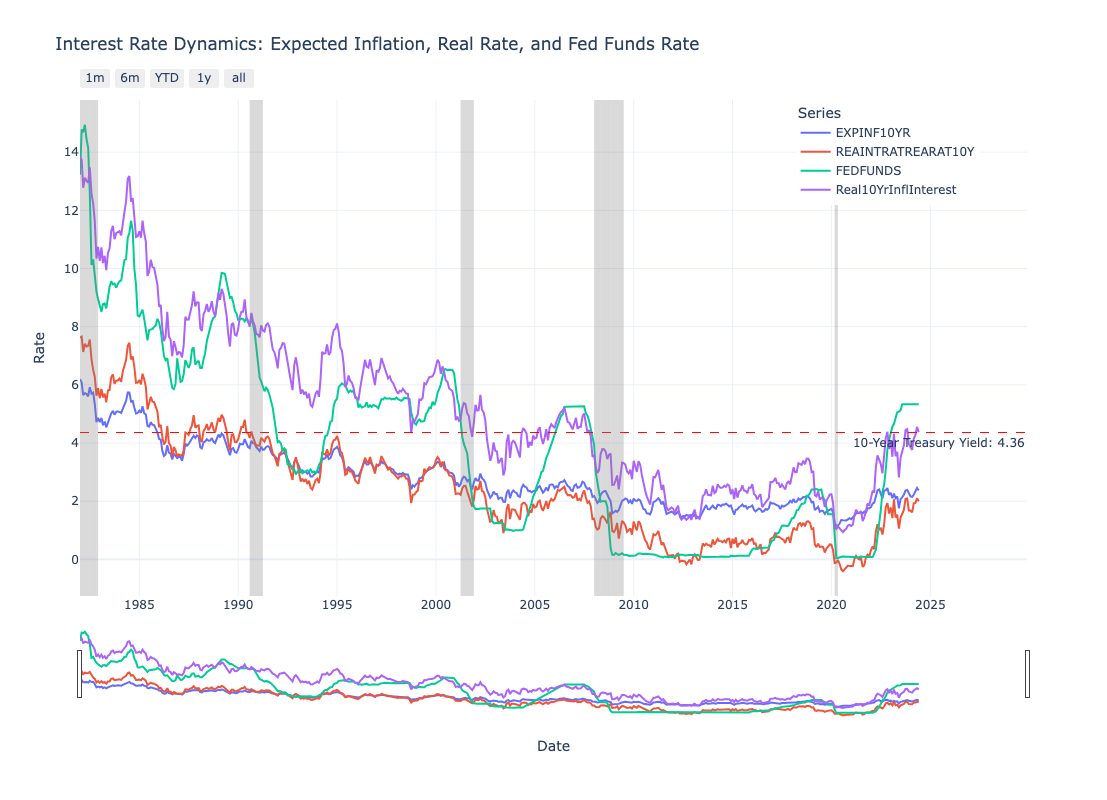

In [75]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(fig, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 2000

    # Construct the RealFlation DataFrame & establish min/max indexed date
    RealFlation = constructDF()
    data_start_date = RealFlation.index.min()
    data_end_date = RealFlation.index.max()
    
    # Create Plotly figure & Add traces for each series
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['EXPINF10YR'], mode='lines', name='EXPINF10YR'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['REAINTRATREARAT10Y'], mode='lines', name='REAINTRATREARAT10Y'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='FEDFUNDS'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['Real10YrInflInterest'], mode='lines', name='Real10YrInflInterest'))

    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'10-Year Treasury Yield: {current_dgs10}', annotation_position='bottom right')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")

    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(data_start_date)
    shade_recession_months(fig, usrec_series)
    
    # Update layout with correct x-axis range and range slider range
    fig.update_layout(
        title='Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        legend=dict(
            x=.95,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the chart
        height=800,  # Set the height of the chart
        xaxis=dict(
            rangeselector=dict(buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])),
            rangeslider=dict(visible=True, range=[data_start_date, data_end_date]), 
            type="date",
            range=[data_start_date, data_end_date + pd.DateOffset(days=offset_days)]
        )
    )
    
    # Show the figure
    fig.show()


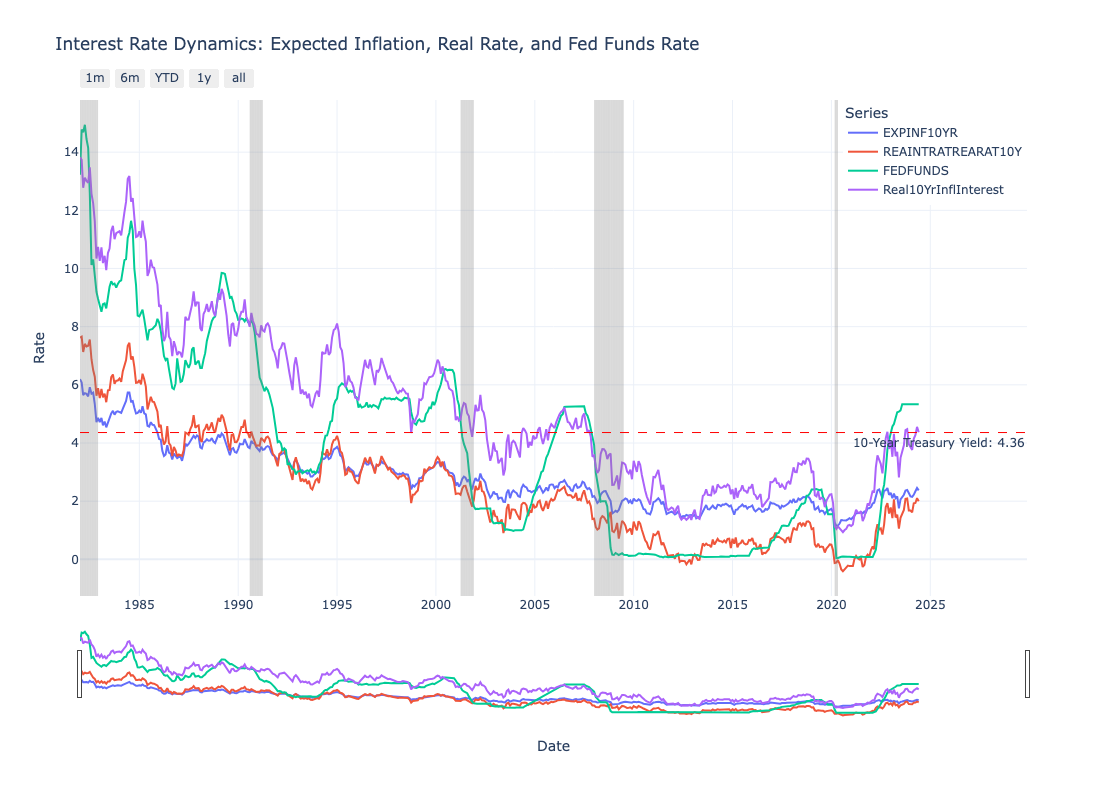

In [11]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def constructDF():
    """
    Constructs the RealFlation DataFrame by fetching data from the FRED API.

    Returns:
        pd.DataFrame: DataFrame containing the data for 'EXPINF10YR', 
                      'REAINTRATREARAT10Y', 'FEDFUNDS', and 'Real10YrInflInterest'.
    """
    expinf10yr = SeriesFetcher('EXPINF10YR')
    reaintratrearat10y = SeriesFetcher('REAINTRATREARAT10Y')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'EXPINF10YR': expinf10yr.get_series_data(),
        'REAINTRATREARAT10Y': reaintratrearat10y.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values
    data.dropna(inplace=True)
    
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['Real10YrInflInterest'] = data['REAINTRATREARAT10Y'] + data['EXPINF10YR']
    
    return data

def shade_recession_months(fig, usrec_series):
    """
    Shades the recession months based on the "USREC" series.

    Parameters:
        fig (plotly.graph_objs._figure.Figure): The Plotly Figure object to add the shaded regions.
        usrec_series (pd.Series): The "USREC" series with dates as index and recession indicators as values.
    """
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 2000
    
    # Construct the RealFlation DataFrame
    RealFlation = constructDF()
    
    # Get the actual data range
    data_start_date = RealFlation.index.min()
    data_end_date = RealFlation.index.max()
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add traces for each series
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['EXPINF10YR'], mode='lines', name='EXPINF10YR'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['REAINTRATREARAT10Y'], mode='lines', name='REAINTRATREARAT10Y'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='FEDFUNDS'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['Real10YrInflInterest'], mode='lines', name='Real10YrInflInterest'))
    
    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(data_start_date)
    shade_recession_months(fig, usrec_series)
    
    # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    dgs10 = SeriesFetcher('DGS10')
    current_dgs10 = dgs10.get_latest_value()
    if current_dgs10 is not None:
        fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'10-Year Treasury Yield: {current_dgs10}', annotation_position='bottom right')
    else:
        print("Failed to fetch the current 10-year Treasury yield.")
    
    # Update layout with correct x-axis range and range slider range
    fig.update_layout(
        title='Interest Rate Dynamics: Expected Inflation, Real Rate, and Fed Funds Rate',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        legend=dict(
            x=1,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the chart
        height=800,  # Set the height of the chart
        xaxis=dict(
            rangeselector=dict(buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])),
            rangeslider=dict(visible=True, range=[data_start_date, data_end_date]), 
            type="date",
            range=[data_start_date, data_end_date + pd.DateOffset(days=offset_days)]
        ),
        yaxis=dict(
            autorange=True  # Enable dynamic y-axis scaling
        )
    )
    
    # Show the figure
    fig.show()
